# Data Science in Aviation Reliability: Predicting Brake Failures in widebody twin-jet Aircraft


Welcome to this interactive learning experience where we will delve into the world of data science with a focus on aviation reliability. In this project, we will develop a predictive model to forecast brake failures in widebody twin-jet aircraft. This notebook will guide you through each step of the process, from understanding and preprocessing data to building and evaluating predictive models. Let's embark on this journey to apply data science in enhancing aviation reliability!


## Section 1: Project overview

#### Objectives
- Understand the practical application of data science in aviation reliability.
- Go through each step of model development for the failure of aircraft components
- Develop a predictive model for twin-jet widebody aircraft brake failures.





#### Dataset Description
- We have flight data of 3 planes
- Each plane has 4 brakes
- Each brake has a temperature sensor
- Each brake has a wear pin which corresponds to the percentage of the brake disc left
- Each brake has 4 electronic brake actuators, of which each has a current sensor

#### Overview of the brakes and their position

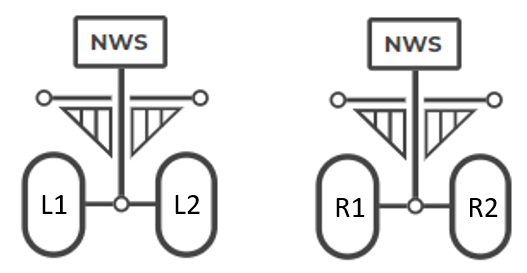

In [36]:
from IPython.display import Image
Image(filename='brakes_total_overview.png')


#### Overview of a single brake, the 4 Electronic Brake actuators and all the sensors that are available for this use case.

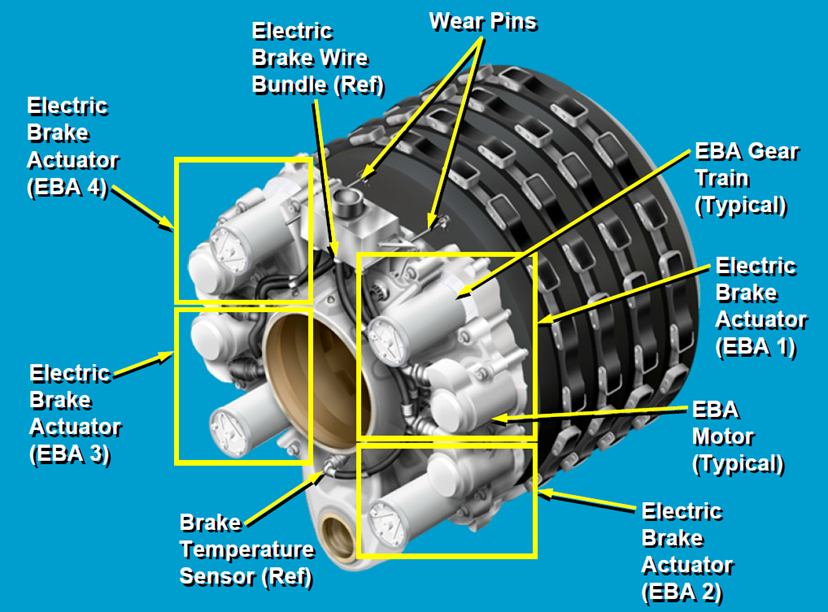

In [35]:
from IPython.display import Image
Image(filename='brake_overview.png')


#### Tools and Libraries
- Python and its powerful libraries like Pandas, NumPy
- Introduction to Jupyter Lab environment.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines


#### Helper functions

In [12]:
def lighten_color(color, amount=0.6):
    """
    Lightens the given color. Color is a tuple of (R, G, B).
    Amount ranges from 0 (color unchanged) to 1 (white).
    """
    r, g, b = color
    r_new = r + (1 - r) * amount
    g_new = g + (1 - g) * amount
    b_new = b + (1 - b) * amount
    return (r_new, g_new, b_new)

def plot_variables_per_tail(variables_to_plot, df, failures, moving_average=False, window_size=5):
    """
    Generates plots for given variables of aircraft, segmented by tail number, with options for moving averages.

    This function iterates over each unique aircraft tail number in the provided DataFrame and generates a plot for each. 
    It plots specified variables and marks the points of failures with vertical lines. 
    There is also an option to display a moving average for each variable.

    Parameters:
    variables_to_plot (list of str): The names of the variables to plot. These should be column names in `df`.
    df (pandas.DataFrame): The DataFrame containing aircraft data. Must include 'plane_tail', 'departure_datetime', 
                           and columns for each variable in `variables_to_plot`.
    failures (list of dict): A list of dictionaries, where each dictionary represents a failure event with keys 
                             'plane_tail', 'departure_datetime', and 'brake_position'.
    moving_average (bool, optional): If True, plots the moving average of each variable. Defaults to False.
    window_size (int, optional): The size of the window used for computing the moving average. Defaults to 5.

    Returns:
    None: The function generates matplotlib plots and does not return any value.

    Notes:
    - The function uses seaborn for styling and matplotlib for plotting.
    - Each tail number from `df['plane_tail']` gets its own plot with all requested variables and failure points.
    - Moving averages are plotted alongside the actual variable values if `moving_average` is set to True.
    - The function assumes that `df` and `failures` are properly formatted and contain the necessary columns.
    """
    # Ensuring seaborn style
    sns.set(style="whitegrid")

    # Extracting unique tails
    unique_tails = df['plane_tail'].unique()

    # Colors and legend handles for failure lines
    brake_colors = {}
    brake_legend_handles = []

    # Creating a plot for each tail and each variable
    for tail in unique_tails:
        tail_data = df[df['plane_tail'] == tail]

        # Create a new figure for each tail
        plt.figure(figsize=(15, 8))
        plt.title(f"Data for tail {tail}")
        
        # Getting distinct colors for each variable
        colors = sns.color_palette("husl", len(variables_to_plot))
        
        # Plotting each variable for the current tail
        for idx, variable in enumerate(variables_to_plot):
            color = colors[idx]
            color_normal = lighten_color(color)
            if moving_average:
                tail_data[variable + '_ma'] = tail_data[variable].rolling(window=window_size).mean()

                plt.plot(tail_data['departure_datetime'], tail_data[variable + '_ma'], label=variable + ' (Moving Avg.)', color=color)
                plt.plot(tail_data['departure_datetime'], tail_data[variable], label=variable, color=color_normal)
            else:
                plt.plot(tail_data['departure_datetime'], tail_data[variable], label=variable, color=color)
            
            # Associate color with brake_position for legend
            brake_position = variable[-3:]
            brake_colors[brake_position] = color
        
        # Adding vertical lines for failures
        for failure in failures:
            if failure["plane_tail"] == tail:
                if failure['brake_position'] in brake_colors:
                    plt.axvline(x=failure["departure_datetime"], color=brake_colors[failure['brake_position']], linestyle='--', linewidth=2.5, zorder=5)
        
        # Create custom legend handles
        brake_legend_handles = [mlines.Line2D([], [], color=color, linestyle='--', linewidth=2.5, label=position + ' failure') for position, color in brake_colors.items()]
                
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles=handles + brake_legend_handles, labels=labels + [handle.get_label() for handle in brake_legend_handles])

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## Section 2: Data Preprocessing


In this section, we will prepare our dataset for analysis and modeling. This involves cleaning data, handling missing values, and feature engineering.

#### Tasks:
- Loading the dataset.
- Identifying and handling missing values, and identyifing and handling unrealistic values or outliers

#### Column Names in `brakes_case_dataset.xlsx`
1. **departure_datetime**: 
   - Description: The date and time when the aircraft departed. 
   - Data Type: DateTime

2. **plane_tail**: 
   - Description: A unique identifier for each aircraft, typically known as the tail number.
   - Data Type: String

3-26. **Brake Disc Percentage and Temperature Measurements**:
   - These columns represent various measurements related to the brake discs and temperatures for different positions on the aircraft. Each column follows a naming convention indicating the measurement type, the side of the aircraft (left or right), and the brake position number. For instance, `disc_percentage_l_1` refers to the disc percentage on the left side of the aircraft at position 1.
   - Data Type: Numeric
   - Columns:
     - `disc_percentage_l_1`: Disc percentage, left side, position 1.
     - `disc_percentage_l_2`: Disc percentage, left side, position 2.
     - `disc_percentage_r_1`: Disc percentage, right side, position 1.
     - `disc_percentage_r_2`: Disc percentage, right side, position 2.
     - `temperature_l_1`: Temperature, left side, position 1.
     - `temperature_l_2`: Temperature, left side, position 2.
     - `temperature_r_1`: Temperature, right side, position 1.
     - `temperature_r_2`: Temperature, right side, position 2.
     - And similarly named columns for `current1`, `current2`, `current3`, `current4` for left and right positions 1 and 2. e.g. `current2_r_1`, corresponds to the current sensor on EBA 2, on the right, position 1 brake.

In [13]:
brakes_df = pd.read_excel('brakes_case_dataset.xlsx')


In [22]:
brakes_df.head(3)

,departure_datetime,plane_tail,disc_percentage_l_1,disc_percentage_l_2,disc_percentage_r_1,disc_percentage_r_2,temperature_l_1,temperature_l_2,temperature_r_1,temperature_r_2,...,current2_r_1,current2_r_2,current3_l_1,current3_l_2,current3_r_1,current3_r_2,current4_l_1,current4_l_2,current4_r_1,current4_r_2
0,2023-01-02 11:46:07,PH-BIH,100.000000,100.000000,99.438003,99.823470,84.754093,61.979052,97.727847,78.591084,...,13.302277,28.134640,2.630098,48.246583,20.223440,19.948842,39.499685,49.755811,4.103617,24.371891
1,2023-01-03 07:43:45,PH-BIH,96.674391,93.757839,97.358516,97.752408,87.535678,59.555928,70.122925,80.438329,...,46.413148,40.803165,46.478059,23.867355,31.875252,14.905398,29.390148,14.215206,15.041468,11.461622
2,2023-01-03 14:30:23,PH-BIH,92.216844,93.896699,93.726970,94.373600,64.217067,91.590632,98.843545,61.917989,...,24.897788,2.331676,1.472955,12.076541,18.702020,4.409861,6.511767,14.398575,14.637782,43.419779


#### Column Names in `failures_list.xlsx`
1. **departure_datetime**: 
   - Description: The date and time when the aircraft departed. This is the flight when a failure was recorded.
   - Data Type: DateTime

2. **plane_tail**: 
   - Description: The unique identifier or tail number of the aircraft. This links the failure event to a specific aircraft.
   - Data Type: String

3. **brake_position**: 
   - Description: Indicates the specific position of the brake where the failure occurred. This refers to various positions on the aircraft's brake system, corresponding to the left or right side and a position number.
   - Data Type: String or Numeric

4. **EBA_pos**: 
   - Description: Abbreviation for Electronic Brake Actuator within the brake system. The position of the failed EBA of a brake.
   - Data Type: Numeric or String (depending on the specific coding used in the dataset)


In [38]:
brakes_df.columns

Index(['departure_datetime', 'plane_tail', 'disc_percentage_l_1',
       'disc_percentage_l_2', 'disc_percentage_r_1', 'disc_percentage_r_2',
       'temperature_l_1', 'temperature_l_2', 'temperature_r_1',
       'temperature_r_2', 'current1_l_1', 'current1_l_2', 'current1_r_1',
       'current1_r_2', 'current2_l_1', 'current2_l_2', 'current2_r_1',
       'current2_r_2', 'current3_l_1', 'current3_l_2', 'current3_r_1',
       'current3_r_2', 'current4_l_1', 'current4_l_2', 'current4_r_1',
       'current4_r_2'],
      dtype='object')

In [24]:
failures_df = pd.read_excel('failures_list.xlsx')
# Convert the DataFrame into a list of dictionaries
failures_list = failures_df.to_dict(orient='records')

In [28]:
failures_list[0:3]

[{'departure_datetime': Timestamp('2023-01-18 22:54:16'),
  'plane_tail': 'PH-BLT',
  'brake_position': 'l_2',
  'EBA_pos': 1.0},
 {'departure_datetime': Timestamp('2023-01-10 20:53:34'),
  'plane_tail': 'PH-BLT',
  'brake_position': 'r_2',
  'EBA_pos': 3.0},
 {'departure_datetime': Timestamp('2023-01-11 09:25:14'),
  'plane_tail': 'PH-BLT',
  'brake_position': 'l_2',
  'EBA_pos': 3.0}]

#### Examples of using the plot_variables_per_tail helper function

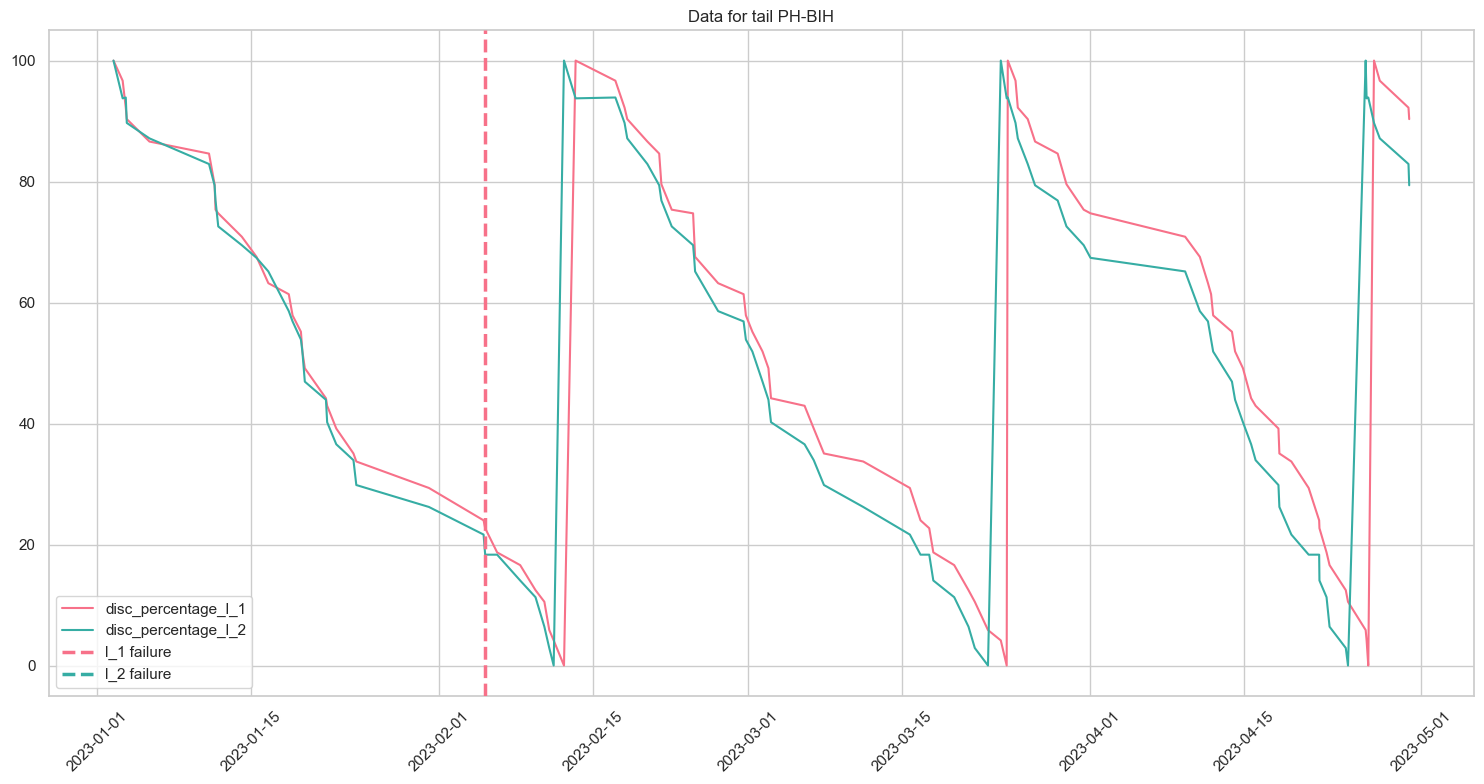

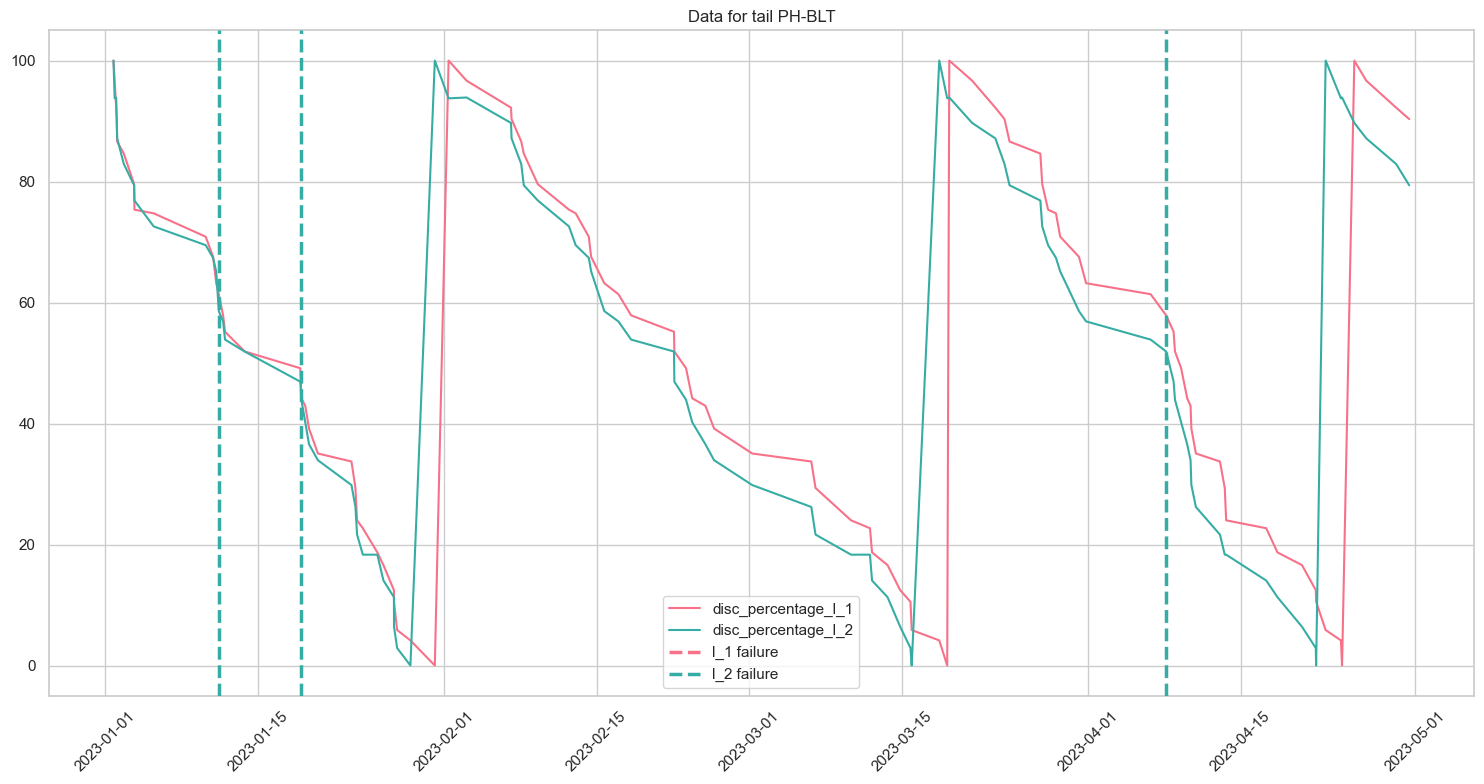

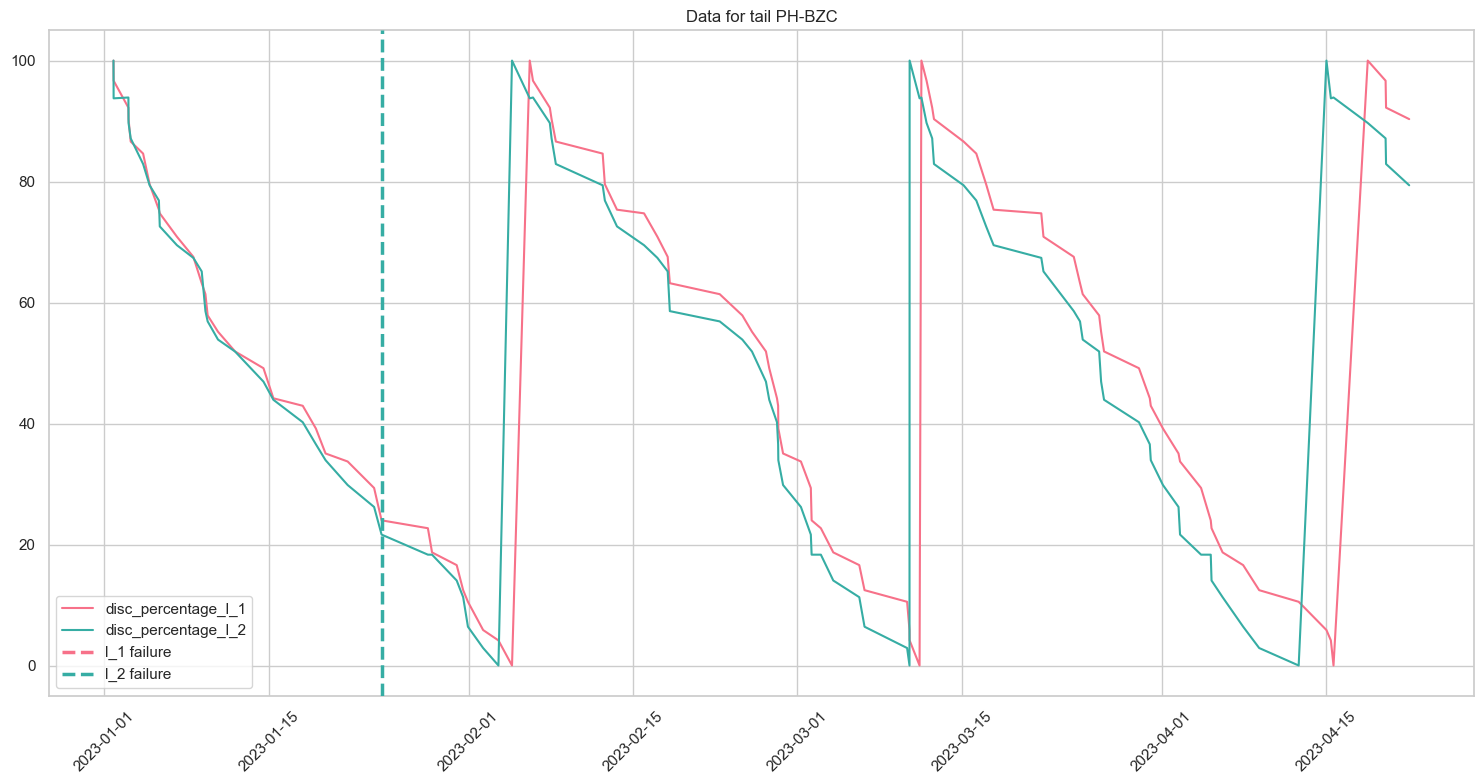

In [33]:
# Usage example
variables_to_plot = [ 'disc_percentage_l_1',
       'disc_percentage_l_2']
plot_variables_per_tail(variables_to_plot, brakes_df, failures_list, moving_average=False)

C:\Users\klm93520\AppData\Local\Temp\ipykernel_16216\2906845284.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail_data[variable + '_ma'] = tail_data[variable].rolling(window=window_size).mean()


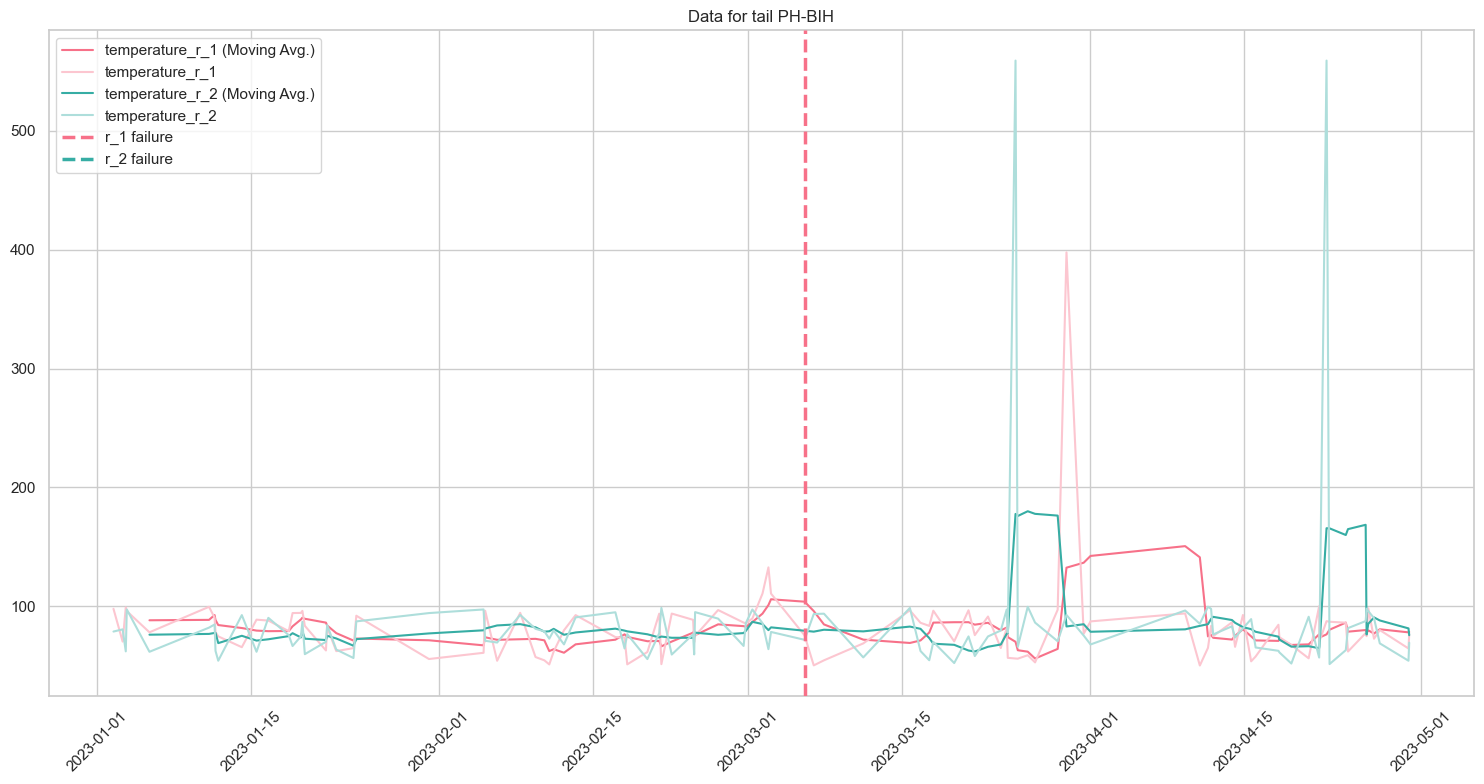

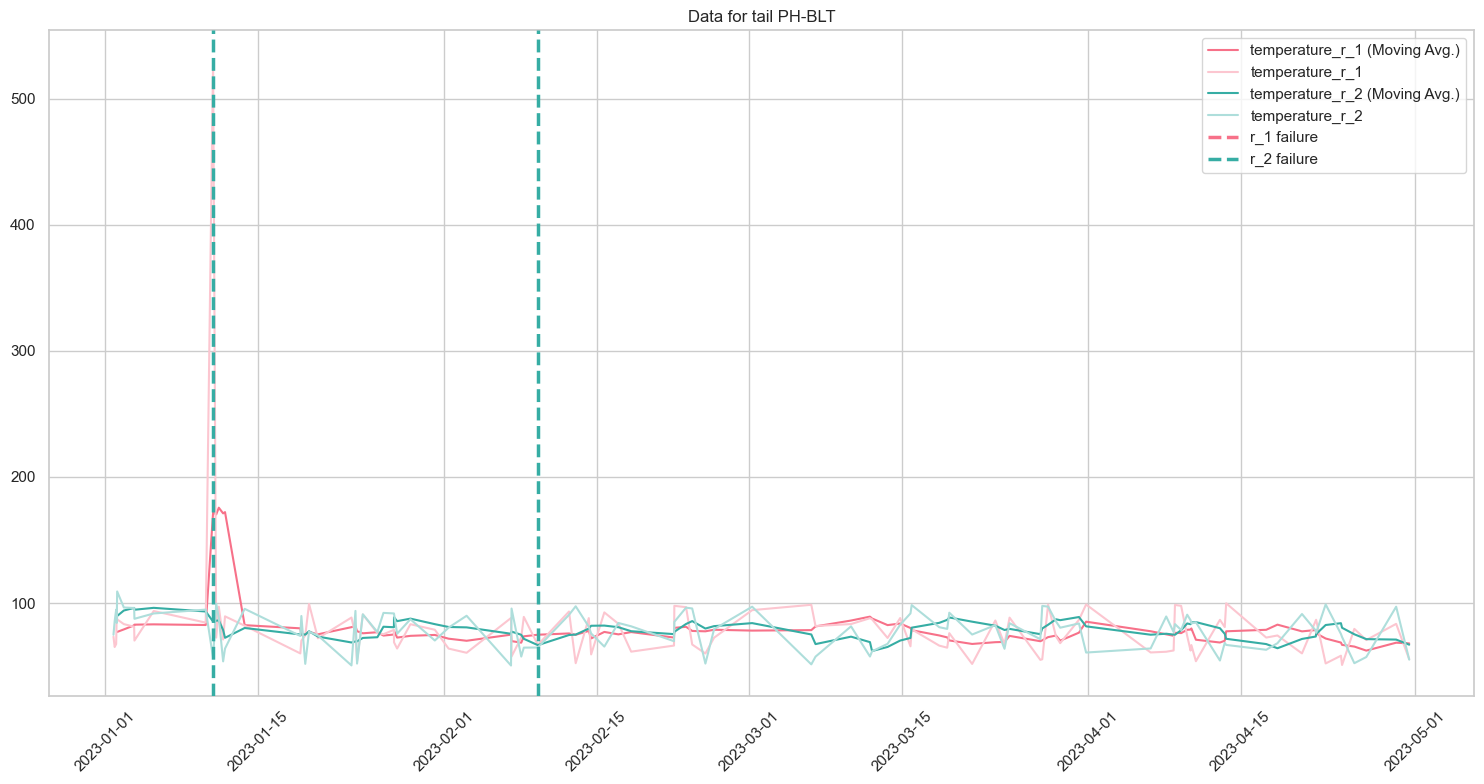

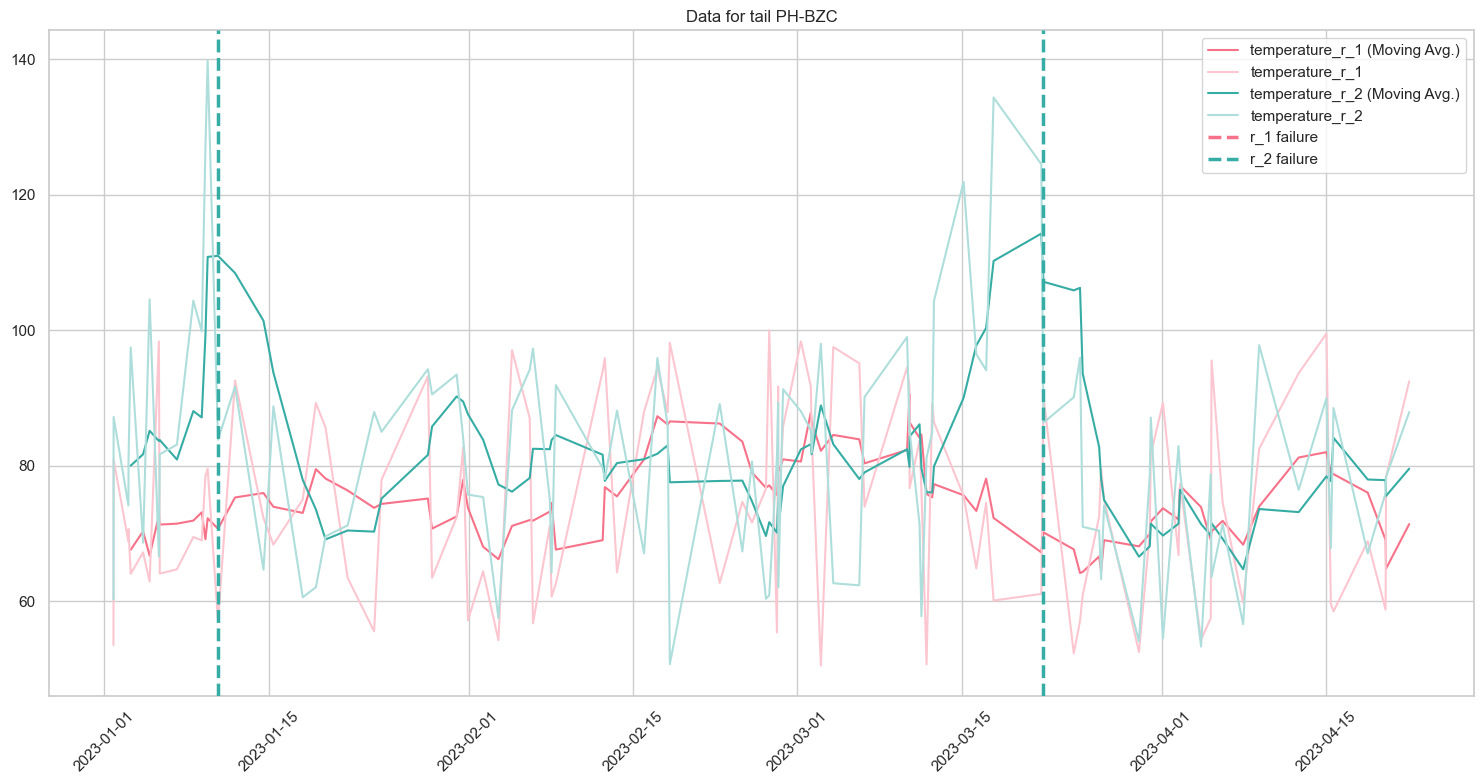

In [32]:
# Usage example
variables_to_plot = ['temperature_r_1','temperature_r_2']
plot_variables_per_tail(variables_to_plot, brakes_df, failures_list, moving_average=True)

## Section 3: Exploratory Data Analysis


Exploratory Data Analysis is crucial for understanding the underlying patterns and characteristics of the data. Here, we'll visualize and explore our data to gain insights.

#### Tasks:
- Statistical summary of the data.
- Feature engineering
- Data visualization: Histograms, box plots, and scatter plots.
- Correlation analysis.

## Section 4: Model Development


With our data ready, we'll now focus on developing predictive models. This involves selecting appropriate algorithms, training models, and performing hyperparameter tuning.

#### Tasks:
- Choosing suitable machine learning algorithms.
- Splitting data into training and testing sets.
- Training models.
- Hyperparameter tuning with cross-validation.

## Section 5: Model Evaluation and Selection


In this section, we evaluate the performance of our models using various metrics and select the best model based on its performance.

#### Tasks:
- Evaluating models using metrics like accuracy, precision, recall, and F1-score.
- Confusion matrix analysis.
- Model comparison and selection.

## Section 6: Conclusion and Reflection


We conclude our project by reflecting on our findings, the effectiveness of our model.

#### Discussion Points:
- Summary of findings.
- Insights gained from the model.
- Potential applications and future scope.
- Overview of potential bottlenecks when the solution is industrialized.
- Reflection on the data science process and learning experience.